In [1]:
import pandas as pd
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import scipy.stats as stats
from sklearn.preprocessing import StandardScaler
from factor_analyzer.factor_analyzer import calculate_kmo
from sklearn.decomposition import FactorAnalysis
import numpy as np
from sklearn.preprocessing import StandardScaler
from factor_analyzer.factor_analyzer import calculate_kmo
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import os
import re
from sklearn.model_selection import cross_val_score
import xgboost as xgb
from xgboost import XGBRegressor
from sklearn.decomposition import PCA
import scipy.stats as stats
from sklearn.preprocessing import StandardScaler
from factor_analyzer.factor_analyzer import calculate_kmo
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import seaborn as sns
from sklearn.decomposition import FactorAnalysis
import optuna

# Check scikit-learn < 1.6.0

In [2]:
df = pd.read_csv('datasets\cleaned_data_QS.csv', encoding='latin1')
score_columns = [col for col in df.columns if 'SCORE' in col]
print(score_columns,'score_columns')
print(df.columns,'all_columns')

['AR_SCORE', 'ER_SCORE', 'FS_SCORE', 'CPF_SCORE', 'IF_SCORE', 'IS_SCORE', 'IRN_SCORE', 'EO_SCORE', 'S_SCORE'] score_columns
Index(['Rank', 'Institution Name', 'Country', 'Year', 'CS', 'CF', 'RI', 'Age',
       'STA', 'AR_SCORE', 'ER_SCORE', 'FS_SCORE', 'CPF_SCORE', 'IF_SCORE',
       'IS_SCORE', 'IRN_SCORE', 'EO_SCORE', 'S_SCORE', 'Overall'],
      dtype='object') all_columns


In [3]:
# select lower missing-value ratio as features(used in model)
features = ['CS', 'CF', 'RI', 'Age', 'STA', 'AR_SCORE', 'ER_SCORE', 'FS_SCORE', 'CPF_SCORE','IF_SCORE','IS_SCORE','Overall']
targets = ['IRN_SCORE', 'EO_SCORE', 'S_SCORE']

# Fill missing values with institution-specific mean
def fill_na_with_institution_mean(df, column):
    return df[column].fillna(df.groupby('Institution Name')[column].transform('mean'))

# If still missing, filling with country-specific mean
def fill_na_with_country_mean(df, column):
    return df[column].fillna(df.groupby('Country')[column].transform('mean'))

# Fill initial columns with country mean
cols_to_exclude = ['Institution Name', 'Country']
for col in features:
    if col not in cols_to_exclude:
        df[col] = fill_na_with_institution_mean(df, col)
        df[col] = fill_na_with_country_mean(df, col)

In [4]:
# Check missing
missing = df[df.columns].isnull().sum().values / df.shape[0]   # Calculate missing values ratio
for i,column in zip(missing, df.columns):
    print(f"{i * 100:.2f}% missing in",column)

0.00% missing in Rank
0.00% missing in Institution Name
0.00% missing in Country
0.00% missing in Year
0.00% missing in CS
0.00% missing in CF
0.00% missing in RI
0.24% missing in Age
0.13% missing in STA
0.02% missing in AR_SCORE
0.02% missing in ER_SCORE
0.02% missing in FS_SCORE
0.02% missing in CPF_SCORE
0.11% missing in IF_SCORE
0.13% missing in IS_SCORE
44.60% missing in IRN_SCORE
44.56% missing in EO_SCORE
58.96% missing in S_SCORE
4.13% missing in Overall


In [5]:
# Combine features and targets for imputation
all_columns = features + targets
# Split data for training and testing
train_data = df[df['Year'] >= 2024].dropna(subset=all_columns)   # ensure training data are have no missing values
test_data = df[df['Year'] < 2024]

In [6]:
def objective(trial, X_train, y_train):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 700),
        'max_depth': trial.suggest_int('max_depth', 3, 7),
        'learning_rate': trial.suggest_float('learning_rate', 0.005, 0.3),
        'subsample': trial.suggest_float('subsample', 0.5, 0.8),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 0.8),
        'reg_alpha': trial.suggest_float('reg_alpha', 0.0, 0.8),
        'reg_lambda': trial.suggest_float('reg_lambda', 0.0, 0.8),
    }
    model = XGBRegressor(**params, random_state=2025, n_jobs=-1, verbosity=0)
    score = cross_val_score(model, X_train, y_train, cv=3, scoring='neg_root_mean_squared_error', n_jobs=-1)
    return -score.mean()

In [7]:
best_params_dict = {}

for target in targets:
    X_train = train_data[features]
    y_train = train_data[target]

    study = optuna.create_study(direction='minimize')
    study.optimize(lambda trial: objective(trial, X_train, y_train), n_trials=100)

    best_params = study.best_params
    best_params_dict[target] = best_params

    best_model = XGBRegressor(**best_params, random_state=2025, n_jobs=-1, verbosity=0)
    best_model.fit(X_train, y_train)

    print(f"Best parameters for {target}: {best_params}")

    X_test = test_data[features]
    test_data.loc[:, target] = best_model.predict(X_test)

[I 2025-07-18 13:16:34,748] A new study created in memory with name: no-name-a44ee5a9-9810-4de3-9437-e53af1063fb2
[I 2025-07-18 13:16:38,198] Trial 0 finished with value: 24.710545696861015 and parameters: {'n_estimators': 425, 'max_depth': 6, 'learning_rate': 0.19172999407908592, 'subsample': 0.7237128351102494, 'colsample_bytree': 0.6133615659641279, 'reg_alpha': 0.5013537927349389, 'reg_lambda': 0.14141976690488223}. Best is trial 0 with value: 24.710545696861015.
[I 2025-07-18 13:16:39,452] Trial 1 finished with value: 23.784443754030224 and parameters: {'n_estimators': 545, 'max_depth': 5, 'learning_rate': 0.046198068363797265, 'subsample': 0.6280886396707042, 'colsample_bytree': 0.7700689453710279, 'reg_alpha': 0.5589901373998177, 'reg_lambda': 0.7871551187684922}. Best is trial 1 with value: 23.784443754030224.
[I 2025-07-18 13:16:41,008] Trial 2 finished with value: 24.417464624013068 and parameters: {'n_estimators': 441, 'max_depth': 7, 'learning_rate': 0.15386866005569186, 's

[I 2025-07-18 13:16:50,047] Trial 23 finished with value: 23.59962180646195 and parameters: {'n_estimators': 465, 'max_depth': 5, 'learning_rate': 0.03887771490986238, 'subsample': 0.7514763682236757, 'colsample_bytree': 0.524413797530603, 'reg_alpha': 0.5369799136823928, 'reg_lambda': 0.37229942837410424}. Best is trial 20 with value: 23.367032750055333.
[I 2025-07-18 13:16:50,376] Trial 24 finished with value: 23.95074102748174 and parameters: {'n_estimators': 340, 'max_depth': 6, 'learning_rate': 0.07595169545609076, 'subsample': 0.6803330871358167, 'colsample_bytree': 0.5421602811501647, 'reg_alpha': 0.35873783258873043, 'reg_lambda': 0.4893315630851934}. Best is trial 20 with value: 23.367032750055333.
[I 2025-07-18 13:16:50,690] Trial 25 finished with value: 24.088952493665744 and parameters: {'n_estimators': 467, 'max_depth': 5, 'learning_rate': 0.1061890998585775, 'subsample': 0.799626204090807, 'colsample_bytree': 0.5813290207746967, 'reg_alpha': 0.5952646573792038, 'reg_lambd

[I 2025-07-18 13:16:57,220] Trial 46 finished with value: 23.29710108026229 and parameters: {'n_estimators': 291, 'max_depth': 7, 'learning_rate': 0.01692238722431326, 'subsample': 0.6961061422811521, 'colsample_bytree': 0.5198172821566867, 'reg_alpha': 0.5180520646137049, 'reg_lambda': 0.4314778369598503}. Best is trial 44 with value: 23.29299047969762.
[I 2025-07-18 13:16:57,454] Trial 47 finished with value: 25.809007370832276 and parameters: {'n_estimators': 242, 'max_depth': 6, 'learning_rate': 0.29744950249221314, 'subsample': 0.6908033896499512, 'colsample_bytree': 0.515885394323252, 'reg_alpha': 0.7016046674799314, 'reg_lambda': 0.07394047321512554}. Best is trial 44 with value: 23.29299047969762.
[I 2025-07-18 13:16:57,626] Trial 48 finished with value: 23.40993766848823 and parameters: {'n_estimators': 300, 'max_depth': 4, 'learning_rate': 0.017847557172889883, 'subsample': 0.7021386491834414, 'colsample_bytree': 0.5184907042842571, 'reg_alpha': 0.5581860562503642, 'reg_lambd

[I 2025-07-18 13:17:04,754] Trial 69 finished with value: 24.611025095986193 and parameters: {'n_estimators': 211, 'max_depth': 7, 'learning_rate': 0.11857079354090723, 'subsample': 0.5698675118044838, 'colsample_bytree': 0.5760400247354102, 'reg_alpha': 0.13276070798691636, 'reg_lambda': 0.033545640786566994}. Best is trial 62 with value: 23.181096359013853.
[I 2025-07-18 13:17:05,052] Trial 70 finished with value: 23.681352277958535 and parameters: {'n_estimators': 170, 'max_depth': 7, 'learning_rate': 0.0686013300630888, 'subsample': 0.6266069308296216, 'colsample_bytree': 0.5913714275835753, 'reg_alpha': 0.20352543750546243, 'reg_lambda': 0.195887209842357}. Best is trial 62 with value: 23.181096359013853.
[I 2025-07-18 13:17:05,476] Trial 71 finished with value: 23.21436389199462 and parameters: {'n_estimators': 251, 'max_depth': 7, 'learning_rate': 0.013532145668692952, 'subsample': 0.6137457665312368, 'colsample_bytree': 0.607707280379955, 'reg_alpha': 0.2142193023217614, 'reg_l

[I 2025-07-18 13:17:11,414] Trial 92 finished with value: 23.238736972564123 and parameters: {'n_estimators': 138, 'max_depth': 7, 'learning_rate': 0.021426705454849485, 'subsample': 0.6723278226472483, 'colsample_bytree': 0.5927224044365615, 'reg_alpha': 0.047232489552640325, 'reg_lambda': 0.05878621208991214}. Best is trial 62 with value: 23.181096359013853.
[I 2025-07-18 13:17:11,675] Trial 93 finished with value: 23.374750752663008 and parameters: {'n_estimators': 155, 'max_depth': 7, 'learning_rate': 0.03630563224425304, 'subsample': 0.6021884462293586, 'colsample_bytree': 0.5932812179149054, 'reg_alpha': 0.0369240545572002, 'reg_lambda': 0.015222959453061048}. Best is trial 62 with value: 23.181096359013853.
[I 2025-07-18 13:17:11,885] Trial 94 finished with value: 23.35217341346058 and parameters: {'n_estimators': 115, 'max_depth': 7, 'learning_rate': 0.020928940896921173, 'subsample': 0.6720961378706155, 'colsample_bytree': 0.6305230820006372, 'reg_alpha': 0.17325072918769402, 

Best parameters for IRN_SCORE: {'n_estimators': 225, 'max_depth': 7, 'learning_rate': 0.013728952270261382, 'subsample': 0.5970348105456936, 'colsample_bytree': 0.5922665594467799, 'reg_alpha': 0.10029555536700752, 'reg_lambda': 0.17089527330124513}


[I 2025-07-18 13:17:14,685] Trial 0 finished with value: 15.209181473313015 and parameters: {'n_estimators': 500, 'max_depth': 7, 'learning_rate': 0.13824053384251103, 'subsample': 0.6047270743625458, 'colsample_bytree': 0.7951148014578113, 'reg_alpha': 0.7949870574933016, 'reg_lambda': 0.12129132908384266}. Best is trial 0 with value: 15.209181473313015.
[I 2025-07-18 13:17:14,956] Trial 1 finished with value: 15.353266690626782 and parameters: {'n_estimators': 537, 'max_depth': 4, 'learning_rate': 0.028990947906970457, 'subsample': 0.7888316782991692, 'colsample_bytree': 0.7898961092788688, 'reg_alpha': 0.7097470102757469, 'reg_lambda': 0.189741031239278}. Best is trial 0 with value: 15.209181473313015.
[I 2025-07-18 13:17:15,210] Trial 2 finished with value: 16.419542179960185 and parameters: {'n_estimators': 397, 'max_depth': 5, 'learning_rate': 0.2504486991060051, 'subsample': 0.5401277706339471, 'colsample_bytree': 0.5278844872198104, 'reg_alpha': 0.10534686961770952, 'reg_lambda

[I 2025-07-18 13:17:25,009] Trial 23 finished with value: 14.875406386297167 and parameters: {'n_estimators': 561, 'max_depth': 6, 'learning_rate': 0.13115141041323766, 'subsample': 0.7611990714838203, 'colsample_bytree': 0.7620534077956507, 'reg_alpha': 0.7298222639177399, 'reg_lambda': 0.3960291296771525}. Best is trial 21 with value: 14.677154162971261.
[I 2025-07-18 13:17:25,336] Trial 24 finished with value: 14.755927021676149 and parameters: {'n_estimators': 337, 'max_depth': 6, 'learning_rate': 0.0792540791124406, 'subsample': 0.694538830938426, 'colsample_bytree': 0.6635588514926175, 'reg_alpha': 0.5865272098202838, 'reg_lambda': 0.49233574073907305}. Best is trial 21 with value: 14.677154162971261.
[I 2025-07-18 13:17:25,756] Trial 25 finished with value: 14.884478007559286 and parameters: {'n_estimators': 623, 'max_depth': 5, 'learning_rate': 0.040579559669758965, 'subsample': 0.6523470476652221, 'colsample_bytree': 0.7113931682519972, 'reg_alpha': 0.4346584567907047, 'reg_la

[I 2025-07-18 13:17:38,170] Trial 46 finished with value: 14.691635337330746 and parameters: {'n_estimators': 462, 'max_depth': 7, 'learning_rate': 0.1127399984477298, 'subsample': 0.7066377098741922, 'colsample_bytree': 0.6238513185270287, 'reg_alpha': 0.7040382781795068, 'reg_lambda': 0.7992218118695988}. Best is trial 36 with value: 14.546523963000922.
[I 2025-07-18 13:17:38,961] Trial 47 finished with value: 15.374476506076206 and parameters: {'n_estimators': 646, 'max_depth': 7, 'learning_rate': 0.2127600127227342, 'subsample': 0.7995920145979234, 'colsample_bytree': 0.5823849944602777, 'reg_alpha': 0.5597848296876677, 'reg_lambda': 0.6164346292574345}. Best is trial 36 with value: 14.546523963000922.
[I 2025-07-18 13:17:39,765] Trial 48 finished with value: 14.573974681038699 and parameters: {'n_estimators': 608, 'max_depth': 7, 'learning_rate': 0.03630596962294746, 'subsample': 0.769389074012844, 'colsample_bytree': 0.6503285868274425, 'reg_alpha': 0.1593097656897795, 'reg_lambd

[I 2025-07-18 13:17:53,682] Trial 69 finished with value: 14.66002475343852 and parameters: {'n_estimators': 666, 'max_depth': 6, 'learning_rate': 0.02478769722413926, 'subsample': 0.7069048623720565, 'colsample_bytree': 0.7651374995782256, 'reg_alpha': 0.23816162687100073, 'reg_lambda': 0.1598262943660961}. Best is trial 58 with value: 14.520658404677997.
[I 2025-07-18 13:17:54,672] Trial 70 finished with value: 14.540339466357437 and parameters: {'n_estimators': 659, 'max_depth': 7, 'learning_rate': 0.019813871378030597, 'subsample': 0.7765652034034832, 'colsample_bytree': 0.7410021860487288, 'reg_alpha': 0.42317684908135583, 'reg_lambda': 0.31903375890037816}. Best is trial 58 with value: 14.520658404677997.
[I 2025-07-18 13:17:55,616] Trial 71 finished with value: 14.512742924952269 and parameters: {'n_estimators': 657, 'max_depth': 7, 'learning_rate': 0.023242183040604884, 'subsample': 0.7787527671300848, 'colsample_bytree': 0.749589971386291, 'reg_alpha': 0.3447237122280309, 'reg

[I 2025-07-18 13:18:15,491] Trial 92 finished with value: 14.671697555946402 and parameters: {'n_estimators': 700, 'max_depth': 7, 'learning_rate': 0.05420976567036194, 'subsample': 0.6057494103438648, 'colsample_bytree': 0.7744572864868382, 'reg_alpha': 0.5467794875413516, 'reg_lambda': 0.20418344791129506}. Best is trial 85 with value: 14.433261701837077.
[I 2025-07-18 13:18:16,473] Trial 93 finished with value: 14.451188463449961 and parameters: {'n_estimators': 675, 'max_depth': 7, 'learning_rate': 0.033001446959159214, 'subsample': 0.6258356319227678, 'colsample_bytree': 0.7298568415898413, 'reg_alpha': 0.4851519243067773, 'reg_lambda': 0.18713832460021615}. Best is trial 85 with value: 14.433261701837077.
[I 2025-07-18 13:18:17,455] Trial 94 finished with value: 14.447093300389454 and parameters: {'n_estimators': 686, 'max_depth': 7, 'learning_rate': 0.0328212442846281, 'subsample': 0.628443871518661, 'colsample_bytree': 0.7264096486019496, 'reg_alpha': 0.4892816447565292, 'reg_l

Best parameters for EO_SCORE: {'n_estimators': 691, 'max_depth': 7, 'learning_rate': 0.04236457819589092, 'subsample': 0.577549687319652, 'colsample_bytree': 0.7591123791757265, 'reg_alpha': 0.531923418210322, 'reg_lambda': 0.24190320465294105}


[I 2025-07-18 13:18:23,284] Trial 0 finished with value: 19.03639594935159 and parameters: {'n_estimators': 481, 'max_depth': 3, 'learning_rate': 0.11755988846635429, 'subsample': 0.6453386085479849, 'colsample_bytree': 0.5896720725435152, 'reg_alpha': 0.15335203068518757, 'reg_lambda': 0.15066707409107638}. Best is trial 0 with value: 19.03639594935159.
[I 2025-07-18 13:18:23,407] Trial 1 finished with value: 19.308447262265627 and parameters: {'n_estimators': 300, 'max_depth': 3, 'learning_rate': 0.2624518064492319, 'subsample': 0.6601130105358888, 'colsample_bytree': 0.7566100579640247, 'reg_alpha': 0.07943397505878665, 'reg_lambda': 0.1757190362450155}. Best is trial 0 with value: 19.03639594935159.
[I 2025-07-18 13:18:23,878] Trial 2 finished with value: 19.63257667724704 and parameters: {'n_estimators': 345, 'max_depth': 7, 'learning_rate': 0.24003773977419118, 'subsample': 0.5021473354807361, 'colsample_bytree': 0.5974653655231902, 'reg_alpha': 0.506961350264443, 'reg_lambda': 0

[I 2025-07-18 13:18:29,687] Trial 23 finished with value: 18.59632883786174 and parameters: {'n_estimators': 175, 'max_depth': 6, 'learning_rate': 0.05007723376250602, 'subsample': 0.5236898401459209, 'colsample_bytree': 0.6144918792490258, 'reg_alpha': 0.46473425542412017, 'reg_lambda': 0.05382337261635567}. Best is trial 16 with value: 18.553241074384104.
[I 2025-07-18 13:18:30,023] Trial 24 finished with value: 18.43369696382706 and parameters: {'n_estimators': 230, 'max_depth': 7, 'learning_rate': 0.06314578226994519, 'subsample': 0.5587994761113517, 'colsample_bytree': 0.6284249086415231, 'reg_alpha': 0.4817090107722889, 'reg_lambda': 0.020621973112371683}. Best is trial 24 with value: 18.43369696382706.
[I 2025-07-18 13:18:30,344] Trial 25 finished with value: 18.98118606007939 and parameters: {'n_estimators': 241, 'max_depth': 7, 'learning_rate': 0.1533995631808362, 'subsample': 0.5598091539150433, 'colsample_bytree': 0.5623138234253379, 'reg_alpha': 0.6898061422985388, 'reg_lam

[I 2025-07-18 13:18:43,391] Trial 46 finished with value: 19.20857148281645 and parameters: {'n_estimators': 608, 'max_depth': 7, 'learning_rate': 0.209259614337892, 'subsample': 0.5985088817819816, 'colsample_bytree': 0.647090759734903, 'reg_alpha': 0.7916549212354157, 'reg_lambda': 0.15354638526701114}. Best is trial 38 with value: 18.001181297952016.
[I 2025-07-18 13:18:44,078] Trial 47 finished with value: 18.11996653006082 and parameters: {'n_estimators': 499, 'max_depth': 7, 'learning_rate': 0.06416646497616679, 'subsample': 0.7164838115061141, 'colsample_bytree': 0.6633460872457593, 'reg_alpha': 0.695184172783942, 'reg_lambda': 0.11105082303743923}. Best is trial 38 with value: 18.001181297952016.
[I 2025-07-18 13:18:44,714] Trial 48 finished with value: 18.294427795173352 and parameters: {'n_estimators': 691, 'max_depth': 6, 'learning_rate': 0.0604220738727688, 'subsample': 0.7193052396478081, 'colsample_bytree': 0.6618840823561899, 'reg_alpha': 0.6983969547994356, 'reg_lambda'

[I 2025-07-18 13:18:56,330] Trial 69 finished with value: 18.116569437687907 and parameters: {'n_estimators': 337, 'max_depth': 7, 'learning_rate': 0.03327418944531765, 'subsample': 0.7762818988603165, 'colsample_bytree': 0.7448725205341171, 'reg_alpha': 0.22298078929551926, 'reg_lambda': 0.6661209562011192}. Best is trial 38 with value: 18.001181297952016.
[I 2025-07-18 13:18:56,814] Trial 70 finished with value: 18.124203260815456 and parameters: {'n_estimators': 310, 'max_depth': 7, 'learning_rate': 0.04639678959585765, 'subsample': 0.7763975014766682, 'colsample_bytree': 0.7385158525254306, 'reg_alpha': 0.01458041077665348, 'reg_lambda': 0.6570569630236132}. Best is trial 38 with value: 18.001181297952016.
[I 2025-07-18 13:18:57,323] Trial 71 finished with value: 18.13067089358363 and parameters: {'n_estimators': 313, 'max_depth': 7, 'learning_rate': 0.04562131827933862, 'subsample': 0.7800690840706859, 'colsample_bytree': 0.739480237313247, 'reg_alpha': 0.12514787815794592, 'reg_l

[I 2025-07-18 13:19:10,056] Trial 92 finished with value: 17.973751958462824 and parameters: {'n_estimators': 380, 'max_depth': 7, 'learning_rate': 0.034584086624606276, 'subsample': 0.7282285810189297, 'colsample_bytree': 0.7640011276778356, 'reg_alpha': 0.08303706653908527, 'reg_lambda': 0.5667702393467992}. Best is trial 90 with value: 17.953888828723702.
[I 2025-07-18 13:19:10,510] Trial 93 finished with value: 17.99740093364807 and parameters: {'n_estimators': 261, 'max_depth': 7, 'learning_rate': 0.038178774046069786, 'subsample': 0.7303745285031916, 'colsample_bytree': 0.7688671250173061, 'reg_alpha': 0.08560344741233115, 'reg_lambda': 0.558495066202786}. Best is trial 90 with value: 17.953888828723702.
[I 2025-07-18 13:19:11,116] Trial 94 finished with value: 17.96697258989683 and parameters: {'n_estimators': 373, 'max_depth': 7, 'learning_rate': 0.03799333168388957, 'subsample': 0.7276379387471169, 'colsample_bytree': 0.7684524514257787, 'reg_alpha': 0.0836647435971658, 'reg_l

Best parameters for S_SCORE: {'n_estimators': 403, 'max_depth': 7, 'learning_rate': 0.04734613782132609, 'subsample': 0.7082159140096435, 'colsample_bytree': 0.7841739531122089, 'reg_alpha': 0.11136290616214914, 'reg_lambda': 0.5331132898956379}


In [8]:
combined_data = pd.concat([test_data, train_data])
combined_data = combined_data.dropna(subset=all_columns) 
combined_data.to_csv('datasets\imputed_data_QS_XGB.csv', index=False)

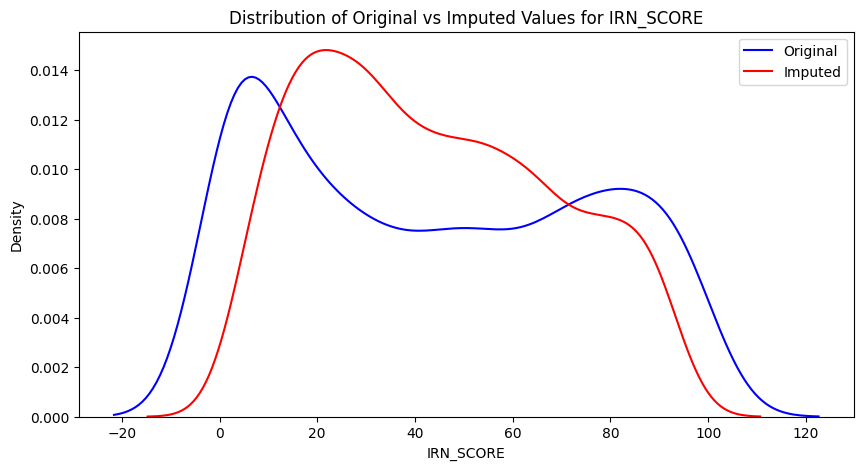

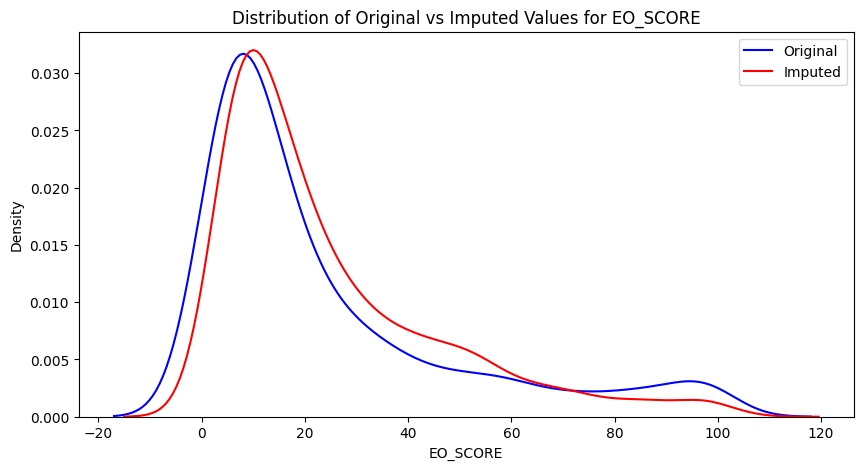

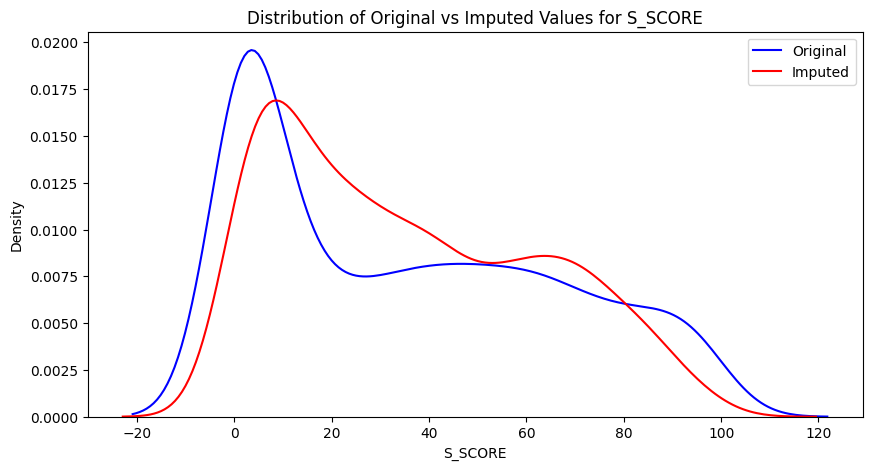

      target       R^2       RMSE        MAE
0  IRN_SCORE  0.668638  18.554286  14.619043
1   EO_SCORE  0.694545  14.162342   9.662768
2    S_SCORE  0.762468  15.238071  11.518370


In [10]:
synthetic_data = train_data.copy().dropna()
for target in targets:
    mask = synthetic_data[target].notna()
    n_to_remove = int(0.35 * mask.sum())
    indices_to_nan = np.random.choice(synthetic_data[mask].index, n_to_remove, replace=False)
    synthetic_data.loc[indices_to_nan, target] = np.nan

# 评估部分
metrics = {'target': [], 'R^2': [], 'RMSE': [], 'MAE': []}

for target in targets:
    train_synthetic = synthetic_data[synthetic_data[target].notna()]
    test_synthetic = synthetic_data[synthetic_data[target].isna()]

    X_train = train_synthetic[features]
    y_train = train_synthetic[target]
    X_test = test_synthetic[features]
    y_true = train_data.loc[test_synthetic.index, target]

    best_params = best_params_dict[target]
    model = XGBRegressor(**best_params, random_state=2025, n_jobs=-1, verbosity=0)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    r2 = r2_score(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)

    metrics['target'].append(target)
    metrics['R^2'].append(r2)
    metrics['RMSE'].append(rmse)
    metrics['MAE'].append(mae)

    # Plot distribution comparison
    plt.figure(figsize=(10, 5))
    sns.kdeplot(y_true, label='Original', color='blue')
    sns.kdeplot(y_pred, label='Imputed', color='red')
    plt.title(f"Distribution of Original vs Imputed Values for {target}")
    plt.xlabel(target)
    plt.legend()
    plt.show()
    
metrics_df = pd.DataFrame(metrics)
print(metrics_df)